# SPEI计算

使用`climate-indices`库直接进行计算。

<https://climate-indices.readthedocs.io/en/latest/index.html#spei-monthly>

In [12]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
from climate_indices import compute, indices, utils
import multiprocessing as mp
import numba as nb
import rasterio
import rioxarray as rxr
#%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
mpl.rcParams['font.family'] = ['SimSun']

文档有点少，先进行测试计算

In [3]:
test_pet_frame = xr.open_dataset('../../outputs/pet-resampled/2000_01.tif').squeeze("band",drop=True)
test_precip_frame = xr.open_dataset('../../outputs/precip-cutted/_2000_2002_1.tif').squeeze("band",drop=True)

In [4]:
test_pet_frame

<xarray.Dataset>
Dimensions:      (x: 840, y: 960)
Coordinates:
  * x            (x) float64 114.0 114.0 114.0 114.0 ... 121.0 121.0 121.0 121.0
  * y            (y) float64 40.0 39.99 39.98 39.97 ... 32.03 32.02 32.01 32.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

In [5]:
test_precip_frame

<xarray.Dataset>
Dimensions:      (x: 840, y: 960)
Coordinates:
  * x            (x) float64 114.0 114.0 114.0 114.0 ... 121.0 121.0 121.0 121.0
  * y            (y) float64 40.0 39.99 39.98 39.97 ... 32.03 32.02 32.01 32.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

这个库文档太少，这里使用手动计算测试

## SPEI计算方法

### 收集相关数据

这里需要逐月降水$P_i$和潜在蒸散发$PET_i$的数据。本节讨论的是单个栅格的情况。

### 计算差值序列

$$ D_i=P_i-PET_i $$

### 将序列推广到时间尺度

$$ D_n^k=\sum_{i=0}^{k-1}(P_{n-i}-PET_{n-i}),\quad n\ge k $$

### 对${D_n^K}$进行正态化

通常认为该差值$D$服从三参数Log-logisitic分布，又称[Fisk分布](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisk.html#scipy-stats-fisk)。

$$ f(x;\kappa,\mu,\lambda)=\frac{\lambda\kappa[\lambda(x-\mu)]^{\kappa-1}}{[1+\lambda^\kappa(x-\mu)^\kappa]^2} $$

其中，$\kappa, \lambda, \mu$分别为形状、尺度和起始参数。对其进行参数估计以得到相关参数。将其带入分布函数

$$ F(x;\kappa,\mu,\lambda)=(1+[\lambda(x-\mu)^\kappa])^{-1} $$

得到序列的概率分布。概率分布函数带入对应$D_i$的值就得到标准化处理之前的SPEI值。

之后进行正态标准化处理，

$$ P=1-F(X) $$

带入标准化计算式，即得SPEI。


先进行数据可视化来验证计算结果

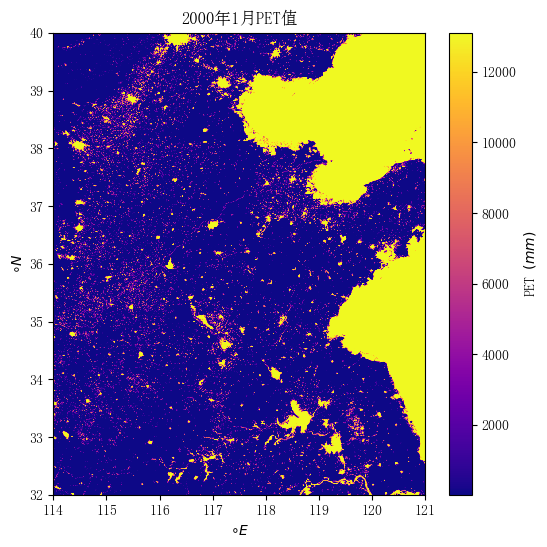

In [18]:
fig,ax = plt.subplots(figsize=(6,6))
test_pet_frame.band_data.plot(ax=ax,cmap='plasma',cbar_kwargs={'label':'PET $(mm)$'})

ax.set_xlabel('$\circ E$')
ax.set_ylabel('$\circ N$')

ax.title.set_text('2000年1月PET值')

PET图中过高的部分是由于水域覆盖引起的。

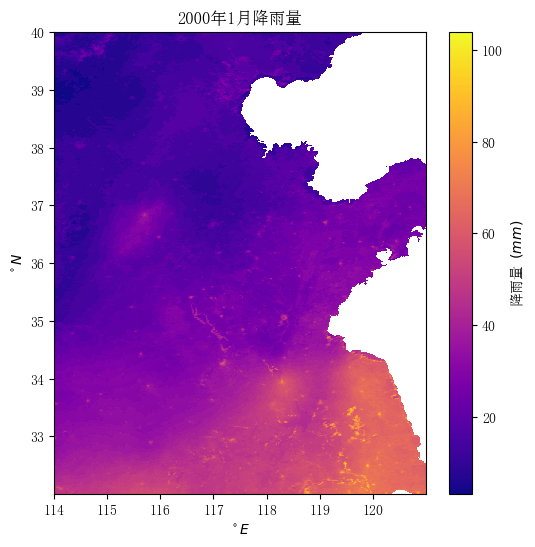

In [17]:
fig,ax = plt.subplots(figsize=(6,6))

(test_precip_frame.band_data*0.1).plot(ax=ax,cmap='plasma',cbar_kwargs={'label':'降雨量 $(mm)$'})

ax.set_xlabel('$^\circ E$')
ax.set_ylabel('$^\circ N$')

ax.title.set_text('2000年1月降雨量')

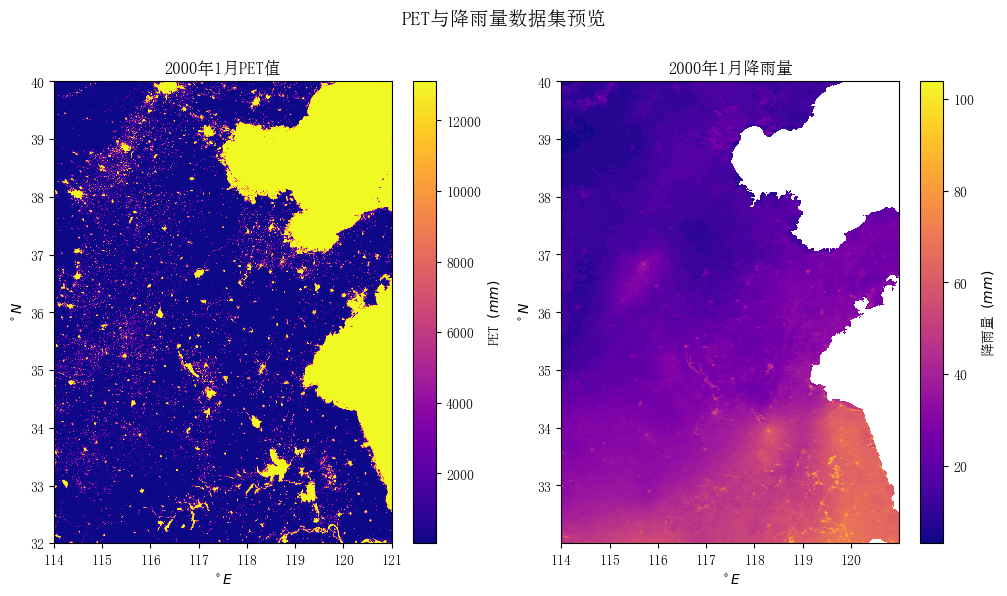

In [26]:
fig,axs = plt.subplots(figsize=(12,6),ncols=2)
test_pet_frame.band_data.plot(ax=axs[0],cmap='plasma',cbar_kwargs={'label':'PET $(mm)$'})

axs[0].set_xlabel('$^\circ E$')
axs[0].set_ylabel('$^\circ N$')

axs[0].title.set_text('2000年1月PET值')

(test_precip_frame.band_data*0.1).plot(ax=axs[1],cmap='plasma',cbar_kwargs={'label':'降雨量 $(mm)$'})

axs[1].set_xlabel('$^\circ E$')
axs[1].set_ylabel('$^\circ N$')

axs[1].title.set_text('2000年1月降雨量')

#fig.suptitle('PET与降雨量数据集预览',y=1.0,fontsize=14)

fig.savefig("./pet-precip-preview.pdf",format='pdf')

可以使用`scipy`中的`scipy.stats.rv_continuous.fit`进行参数估计

运算量过大，重采样到分辨率的十分之一后再构建差值序列

In [ ]:
@nb.jit(parallel=True)
def read_precip():
    filename_lst = []
    base_dir = "../../outputs/precip-cutted/"
    for i in range(0,6):
        year = 2000 + i*3
        for j in range(1,37):
            month = j
            filename_lst.append(base_dir + "_" + str(year) + "_" +str(year+2)+"_"+ str(month) + ".tif")
    filename_lst = filename_lst[0:192]
    
    data_frame = []
    for i in filename_lst:
        print(i)
        test_precip_frame = xr.open_dataset(i).squeeze("band",drop=True)
        test_precip_frame_resampled = test_precip_frame.rio.reproject(test_precip_frame.rio.crs,shape=(96,84),resampling=rasterio.enums.Resampling.bilinear)
        data_frame.append((test_precip_frame_resampled.band_data*0.1).to_numpy())
    return np.array(data_frame)

precip_monthly_mat=read_precip()

../../outputs/precip-cutted/_2000_2002_1.tif
../../outputs/precip-cutted/_2000_2002_2.tif
../../outputs/precip-cutted/_2000_2002_3.tif
../../outputs/precip-cutted/_2000_2002_4.tif
../../outputs/precip-cutted/_2000_2002_5.tif
../../outputs/precip-cutted/_2000_2002_6.tif
../../outputs/precip-cutted/_2000_2002_7.tif
../../outputs/precip-cutted/_2000_2002_8.tif
../../outputs/precip-cutted/_2000_2002_9.tif
../../outputs/precip-cutted/_2000_2002_10.tif
../../outputs/precip-cutted/_2000_2002_11.tif
../../outputs/precip-cutted/_2000_2002_12.tif
../../outputs/precip-cutted/_2000_2002_13.tif
../../outputs/precip-cutted/_2000_2002_14.tif
../../outputs/precip-cutted/_2000_2002_15.tif
../../outputs/precip-cutted/_2000_2002_16.tif
../../outputs/precip-cutted/_2000_2002_17.tif
../../outputs/precip-cutted/_2000_2002_18.tif
../../outputs/precip-cutted/_2000_2002_19.tif
../../outputs/precip-cutted/_2000_2002_20.tif
../../outputs/precip-cutted/_2000_2002_21.tif
../../outputs/precip-cutted/_2000_2002_22.t

In [ ]:
@nb.jit(parallel=True)
def read_pet():
    filename_lst = []
    base_dir = "../../outputs/pet-resampled/"
    for i in range(2000,2016):
        year = i
        for j in range(1,13):
            month = j
            filename_lst.append(base_dir + str(year) + "_" + str(month).zfill(2) + ".tif")

    data_frame = []
    for i in filename_lst:
        print(i)
        test_pet_frame = xr.open_dataset(i).squeeze("band",drop=True)
        test_pet_frame_resampled = test_pet_frame.rio.reproject(test_pet_frame.rio.crs,shape=(96,84),resampling=rasterio.enums.Resampling.bilinear)
        data_frame.append(test_pet_frame_resampled.band_data.to_numpy())
    return np.array(data_frame)

pet_monthly_mat=read_pet()

../../outputs/pet-resampled/2000_01.tif
../../outputs/pet-resampled/2000_02.tif
../../outputs/pet-resampled/2000_03.tif
../../outputs/pet-resampled/2000_04.tif
../../outputs/pet-resampled/2000_05.tif
../../outputs/pet-resampled/2000_06.tif
../../outputs/pet-resampled/2000_07.tif
../../outputs/pet-resampled/2000_08.tif
../../outputs/pet-resampled/2000_09.tif
../../outputs/pet-resampled/2000_10.tif
../../outputs/pet-resampled/2000_11.tif
../../outputs/pet-resampled/2000_12.tif
../../outputs/pet-resampled/2001_01.tif
../../outputs/pet-resampled/2001_02.tif
../../outputs/pet-resampled/2001_03.tif
../../outputs/pet-resampled/2001_04.tif
../../outputs/pet-resampled/2001_05.tif
../../outputs/pet-resampled/2001_06.tif
../../outputs/pet-resampled/2001_07.tif
../../outputs/pet-resampled/2001_08.tif
../../outputs/pet-resampled/2001_09.tif
../../outputs/pet-resampled/2001_10.tif
../../outputs/pet-resampled/2001_11.tif
../../outputs/pet-resampled/2001_12.tif
../../outputs/pet-resampled/2002_01.tif


需要对nan值进行预处理

In [ ]:
d_monthly_mat = precip_monthly_mat - pet_monthly_mat
d_monthly_mat.shape

(192, 96, 84)

In [ ]:
d_3month_mat = np.array([np.sum(d_monthly_mat[i:i+3],axis=0) for i in range(0,192,3)])
d_3month_mat.shape

(64, 96, 84)

In [ ]:

def get_fisk_dist_para(d_dis):  
    d_dis = d_dis[~np.isnan(d_dis)]
    if len(d_dis) == 0:
        return np.nan
    para = sp.stats.fisk.fit(d_dis)
    return para


def get_p_value(d_dis, para):
    p_value = 1-sp.stats.fisk.cdf(d_dis, *para)
    return p_value

def standardize_p(p):
    spei_lst = []
    c0,c1,c2,d1,d2,d3 = 2.515517,0.802853,0.010328,1.432788,0.189269,0.001308
    for i in p:
        if i <= 0.5:
            w = np.sqrt(-2*np.log(i))
            spei = w - (c0+c1*w+c2*(w**2))/(1+d1*w+d2*(w**2)+d3*(w**3))
        elif i > 0.5:
            w = np.sqrt(-2*np.log(1-i))
            spei = -(w - (c0+c1*w+c2*(w**2))/(1+d1*w+d2*(w**2)+d3*(w**3)))
        spei_lst.append(spei)
    return np.array(spei_lst)


In [ ]:

def calc_spei(d_dis):

        para = get_fisk_dist_para(d_dis)
        if para is np.nan:
            return np.nan

        p = get_p_value(d_dis, para)
        spei = standardize_p(p)

        return spei

SPEI计算方式定义完成。接下来计算逐月份SPEI指数。

In [ ]:
print(d_monthly_mat[0,:,:].shape)
print(d_monthly_mat.shape)
print(len(d_monthly_mat[:,0,0]))

(96, 84)
(192, 96, 84)
192


In [ ]:
lat=96

In [ ]:
lon=84

In [ ]:
monthly_spei_mat = np.empty_like(d_monthly_mat)

multi_paras = []

In [ ]:
for i in range(lat):
    for j in range(lon):
        multi_paras.append([i,j])
#print(multi_paras)

In [ ]:
pool = mp.Pool(processes=mp.cpu_count())

multi_results = pool.map(calc_spei,[d_monthly_mat[:,i,j] for i,j in multi_paras])


array([[[ 1.0075079 ,  1.0227146 ,  1.0228549 , ...,         nan,
                 nan,         nan],
        [ 1.0235969 ,  1.0181253 ,  1.0189909 , ...,         nan,
                 nan,         nan],
        [ 0.98989266,  1.002167  ,  1.0051607 , ...,         nan,
                 nan,         nan],
        ...,
        [ 0.96338886,  0.97119385,  0.97233474, ...,  1.035395  ,
          1.0426581 ,  1.0087584 ],
        [ 0.91356474,  0.73130935,  0.98037565, ...,  0.99821603,
          0.8677674 ,  1.0089926 ],
        [ 0.9567012 ,  0.87090504,  0.9331922 , ...,         nan,
          0.9347303 ,  0.9987741 ]],

       [[ 1.0065581 ,  1.0081397 ,  1.0070058 , ...,         nan,
                 nan,         nan],
        [ 1.0056696 ,  1.0034199 ,  1.0013452 , ...,         nan,
                 nan,         nan],
        [ 0.9852013 ,  1.0176184 ,  1.0443571 , ...,         nan,
                 nan,         nan],
        ...,
        [ 1.0963616 ,  1.001055  ,  0.95094836, ...,  

In [ ]:
for i in range(lat):
    for j in range(lon):
        monthly_spei_mat[:,lat-i-1,j] = multi_results[i*lon+j]

monthly_spei_mat

array([[[ 0.9567012 ,  0.87090504,  0.9331922 , ...,         nan,
          0.9347303 ,  0.9987741 ],
        [ 0.91356474,  0.73130935,  0.98037565, ...,  0.99821603,
          0.8677674 ,  1.0089926 ],
        [ 0.96338886,  0.97119385,  0.97233474, ...,  1.035395  ,
          1.0426581 ,  1.0087584 ],
        ...,
        [ 0.98989266,  1.002167  ,  1.0051607 , ...,         nan,
                 nan,         nan],
        [ 1.0235969 ,  1.0181253 ,  1.0189909 , ...,         nan,
                 nan,         nan],
        [ 1.0075079 ,  1.0227146 ,  1.0228549 , ...,         nan,
                 nan,         nan]],

       [[ 1.0304307 ,  1.0032154 ,  0.9609874 , ...,         nan,
          1.338138  ,  1.099575  ],
        [ 1.288503  ,  1.0201607 ,  0.9913052 , ...,  1.0097715 ,
          0.77293265,  0.9913766 ],
        [ 1.0963616 ,  1.001055  ,  0.95094836, ...,  1.0217862 ,
          0.99503773,  1.0312831 ],
        ...,
        [ 0.9852013 ,  1.0176184 ,  1.0443571 , ...,  

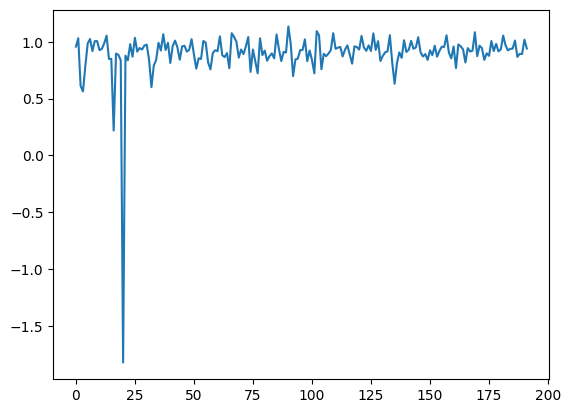

In [ ]:
t=monthly_spei_mat[:,0,0]
plt.plot(t)

In [ ]:
monthly_spei = monthly_spei_mat.copy()

In [ ]:
monthly_spei.shape

(192, 96, 84)

In [ ]:
test_pet_frame = xr.open_dataset('../../outputs/pet-resampled/2000_10.tif').squeeze("band",drop=True)
test_pet_frame_resampled = test_pet_frame.rio.reproject(test_pet_frame.rio.crs,shape=(96,84),resampling=rasterio.enums.Resampling.bilinear)


In [ ]:
month = np.array([i for i in range(1,193)])

latArr = sorted(test_pet_frame_resampled.coords['y'])
lonArr = sorted(test_pet_frame_resampled.coords['x'])

In [ ]:
spei_frame = xr.Dataset(
 data_vars = {
        'spei':(['month','y','x'],monthly_spei)
 },
 coords={
        'x': (['x'], lonArr),
        'y': (['y'], latArr),
        'month':month
 }
)

In [ ]:
spei_frame.rio.write_crs(4326, inplace=True).rio.set_spatial_dims(x_dim="x",y_dim="y",inplace=True).rio.write_coordinate_system(inplace=True)

<xarray.Dataset>
Dimensions:      (month: 192, y: 96, x: 84)
Coordinates:
  * x            (x) float64 114.0 114.1 114.2 114.3 ... 120.7 120.8 120.9 121.0
  * y            (y) float64 32.04 32.12 32.21 32.29 ... 39.71 39.8 39.88 39.96
  * month        (month) int64 1 2 3 4 5 6 7 8 ... 186 187 188 189 190 191 192
    spatial_ref  int64 0
Data variables:
    spei         (month, y, x) float32 0.9567 0.8709 0.9332 ... nan nan nan

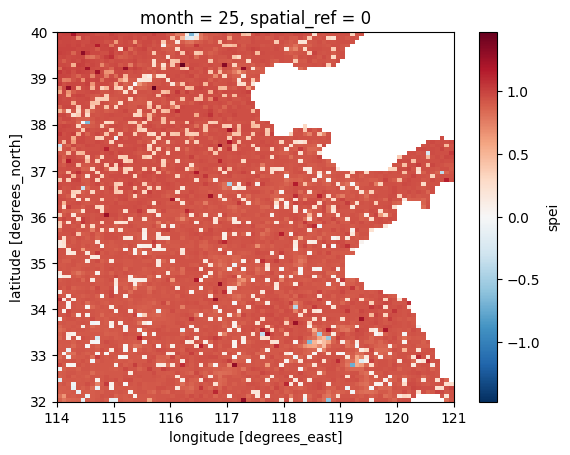

In [ ]:
spei_frame.loc[dict(month=25)].spei.plot()

保存数据到netcdf文件

In [ ]:
spei_frame.to_netcdf("./spei_monthly_2000_2015.nc")

In [ ]:
month3_spei_mat = np.empty_like(d_3month_mat)

pool = mp.Pool(processes=mp.cpu_count())

multi_results = pool.map(calc_spei,[d_3month_mat[:,i,j] for i,j in multi_paras])

In [ ]:
for i in range(lat):
    for j in range(lon):
        month3_spei_mat[:,lat-i-1,j] = multi_results[i*lon+j]
        

In [ ]:
month3_spei_mat.shape

(64, 96, 84)

In [ ]:
spei3_frame = xr.Dataset(
    data_vars = {
        'spei':(['month','y','x'],month3_spei_mat)

    },
    coords={
        'x': (['x'], lonArr),
        'y': (['y'], latArr),

        'month':np.array([i for i in range(1,65)])
    }
)

In [ ]:
spei3_frame.rio.write_crs(4326, inplace=True).rio.set_spatial_dims(x_dim="x",y_dim="y",inplace=True).rio.write_coordinate_system(inplace=True)

<xarray.Dataset>
Dimensions:      (month: 64, y: 96, x: 84)
Coordinates:
  * x            (x) float64 114.0 114.1 114.2 114.3 ... 120.7 120.8 120.9 121.0
  * y            (y) float64 32.04 32.12 32.21 32.29 ... 39.71 39.8 39.88 39.96
  * month        (month) int64 1 2 3 4 5 6 7 8 9 ... 56 57 58 59 60 61 62 63 64
    spatial_ref  int64 0
Data variables:
    spei         (month, y, x) float32 0.9396 0.9061 0.8517 ... nan nan nan

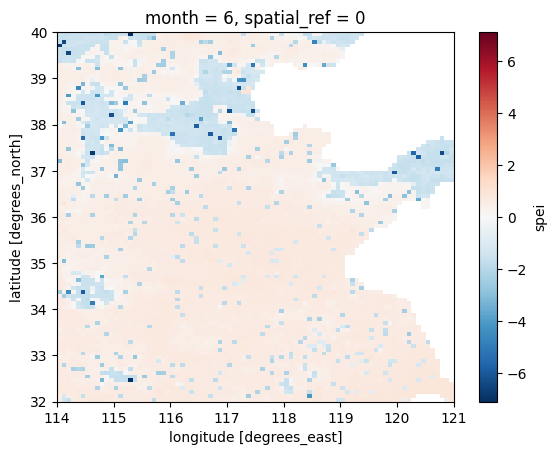

In [ ]:
spei3_frame.loc[dict(month=6)].spei.plot()

In [ ]:
spei3_frame.to_netcdf("./spei_3month_2000_2015.nc")